# Aim of the Homework

* LeNet on MINIST

* LeNet on MedMNIST

**Dataset Ref**: https://zenodo.org/record/4269852#.X7TM-sYzaqA

**Related code Ref**: https://github.com/MedMNIST/MedMNIST

https://github.com/MedMNIST/MedMNIST/blob/main/medmnist/dataset.py

* ResNet on MINIST

* ResNet on MedMNIST

# LeNet on MINIST

In [52]:
import os
import sys
import json
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import sklearn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable

In [2]:
from sklearn.datasets import fetch_openml
mnist =fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

In [39]:
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset, TensorDataset
np.random.seed(42)


In [45]:
def load_data(train_batch_size, test_batch_size):
    # Fetch training data: total 60000 samples
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    # Fetch test data: total 10000 samples
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)

In [48]:
train_batch_size = 128
test_batch_size = 1000
trainloader, testloader = load_data(train_batch_size, test_batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


**尝试两种LeNet，一种是普通的，一种是带有Dropout的**

In [56]:
class selfLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
   
    
net1=selfLeNet()

In [70]:
class LeNetdrop(nn.Module):
    def __init__(self):
        super(LeNetdrop, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6,16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16*5*5, 50)
        self.fc2 = nn.Linear(50, 10)
        
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
net1_drop=LeNetdrop()

**LeNet ref**: https://www.kaggle.com/vincentman0403/pytorch-v0-3-1b-on-mnist-by-lenet
 
**With Dropout** https://nextjournal.com/gkoehler/pytorch-mnist

In [66]:
lr = 0.001
n_epochs = 1000

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [58]:
losses_train=[]
for epoch in range(2):  # loop over the dataset multiple times

    
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs= Variable(inputs)
        labels=Variable(labels)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())
        # print statistics
        #running_loss += loss.item()

In [59]:
total = 0 
correct=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images= Variable(images)
        labels=Variable(labels)
        
        outputs = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 92 %


**不带dropout的LeNet的准确率相对比较满意。**

In [73]:
lr = 0.001
n_epochs = 1000

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net1_drop.parameters(), lr=0.001, momentum=0.9)

losses_train=[]
for epoch in range(2):  # loop over the dataset multiple times

    
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs= Variable(inputs)
        labels=Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1_drop(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())
        # print statistics
        #running_loss += loss.item()
        
total = 0 
correct=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images= Variable(images)
        labels=Variable(labels)
        
        outputs = net1_drop(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 9 %


**So it seems that there's some thing wrong with the dropout machanism in the second network "LeNetdrop", since the accuracy is frustrating. But I can't figure out why because I have used the same paras in conv layers.**

# ResNet on MINIST

**ResNet Ref**: https://github.com/LukasMut/ResNet-in-PyTorch/blob/master/ResNet%20in%20PyTorch.ipynb



In [88]:
def conv(in_size, out_size, pad=1): 
    return nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=pad)


class ResBlock(nn.Module):
    
    def __init__(self, in_size:int, hidden_size:int, out_size:int, pad:int):
        super().__init__()
        self.conv1 = conv(in_size, hidden_size,pad)
        self.conv2 = conv(hidden_size, out_size,pad)
        self.batchnorm1 = nn.BatchNorm2d(hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(out_size)
    
    def convblock(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        return x
    
    def forward(self, x): return x + self.convblock(x) # skip connection

In [97]:


class selfResNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.res1 = ResBlock(1, 8, 16,15)
        self.res2 = ResBlock(16, 32, 16, 15)
        self.conv = conv(16, n_classes)
        self.batchnorm = nn.BatchNorm2d(n_classes)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.res1(x)
        x = self.res2(x) 
        x = self.maxpool(self.batchnorm(self.conv(x)))
        return x.view(x.size(0), -1)
    
net2 = selfResNet()
    

    
optimizer = optim.SGD(net2.parameters(), lr=lr, momentum=0.9)

In [84]:
x_tensor = torch.from_numpy(X).float()
x_tensor = x_tensor.reshape((-1,28, 28))
y_tensor = torch.from_numpy(y).long()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, test_dataset = random_split(dataset, [50000, 20000])

trainloader = DataLoader(dataset=train_dataset, batch_size=400,shuffle=True)

testloader = DataLoader(dataset=test_dataset, batch_size=400,shuffle=False)


In [98]:

losses_train=[]
for epoch in range(1):  # loop over the dataset multiple times    
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs= Variable(inputs)
        labels=Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())
        # print statistics
        #running_loss += loss.item()

In [99]:
total = 0 
correct=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images= Variable(images)
        labels=Variable(labels)
        
        outputs = net2(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 17 %


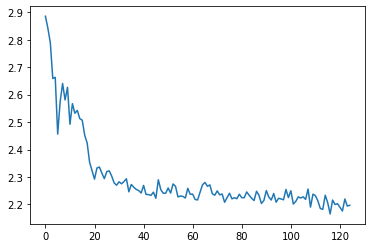

In [100]:
plt.plot(losses_train)

**很奇怪，ResNet的结果比LeNet更差，还差到离谱。但是看了下其他的代码，感觉设计没啥区别，说是过拟合也说不上。**

# LeNet on MedMNIST

**先从官网上下载`retinamnist`数据集，该数据集有3个channel，5个label。先进行数据预处理。**

**code ref**: https://github.com/MedMNIST/MedMNIST/blob/main/medmnist/models.py

In [104]:
data_flag = 'retinamnist'

input_root = './'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001




n_channels =3

n_label={
            "0": "0",
            "1": "1",
            "2": "2",
            "3": "3",
            "4": "4"
        },
n_classes =5

In [153]:
npz_file= np.load('retinamnist.npz')
img_train = npz_file['train_images']
label_train = npz_file['train_labels']
label_train=label_train.astype(np.uint8)

img_test = npz_file['test_images']
label_test = npz_file['test_labels']
label_test=label_test.astype(np.uint8)


img_train_tensor = torch.from_numpy(img_train).float()
img_train_tensor=img_train_tensor.reshape((-1,3,28,28))
label_train_tensor = torch.from_numpy(label_train).long()
train_dataset=TensorDataset(img_train_tensor,label_train_tensor)

img_test_tensor = torch.from_numpy(img_test).float()
img_test_tensor =img_test_tensor.reshape((-1,3,28,28))
label_test_tensor = torch.from_numpy(label_test).long()
test_dataset=TensorDataset(img_test_tensor,label_test_tensor)




from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset, TensorDataset
np.random.seed(42)

trainloader = DataLoader(dataset=train_dataset, batch_size=40,shuffle=True)

testloader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

**接下来应用ResNet，不带dropout**

In [162]:
class selfLeNet2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(selfLeNet2, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    
net3=selfLeNet2(in_channels=n_channels, num_classes=n_classes)

In [163]:


lr = 0.001
n_epochs = 1000

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

In [166]:
losses_train=[]
for epoch in range(2):  # loop over the dataset multiple times    
    for inputs, labels in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        labels=labels.squeeze().long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())
        # print statistics
        #running_loss += loss.item()

100%|██████████| 27/27 [00:01<00:00, 16.53it/s]


In [167]:
total = 0 
correct=0
with torch.no_grad():
    for images, labels in tqdm(testloader):
        labels=labels.squeeze().long()
        outputs = net3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

100%|██████████| 10/10 [00:00<00:00, 49.29it/s]

Accuracy of the network on the test images: 44 %


**在MedMnist数据集里面，准确率没有在Mnist里面高，这也与https://blog.csdn.net/c9Yv2cf9I06K2A9E/article/details/109541372 里面的结论类似。**

# ResNet on MedMNIST

**Code Ref**： https://github.com/MedMNIST/MedMNIST/blob/main/medmnist/models.py

In [156]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)


def ResNet50(in_channels, num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], in_channels=in_channels, num_classes=num_classes)

In [157]:
net4 =ResNet18(in_channels=n_channels, num_classes=n_classes)
    

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(net4.parameters(), lr=lr, momentum=0.9)

In [160]:
losses_train=[]
for epoch in range(2):  # loop over the dataset multiple times    
    for inputs, labels in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        labels=labels.squeeze().long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())
        # print statistics
        #running_loss += loss.item()

100%|██████████| 27/27 [00:49<00:00,  1.83s/it]


In [161]:
total = 0 
correct=0
with torch.no_grad():
    for images, labels  in tqdm(testloader):
        labels=labels.squeeze().long()
        outputs = net4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Accuracy of the network on the test images: 50 %


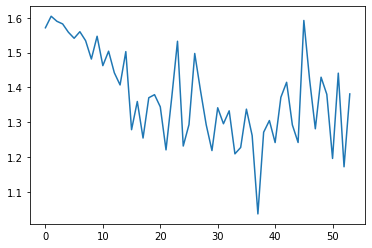

In [168]:
plt.plot(losses_train)

**用Resnet比在Lenet下好了一点点，但是也才50%，特别是观察训练集数据loss下降图时，发现20步以后基本上波动很大，没有明显的下降趋势，所以增加epoch可能并不会提升太多。**

# Summary

* **总体而言，不带dropout的LeNet在MNIST数据集中表现最好，而ResNet和带Dropout的case却奇怪地差得离谱，但是我检查了code来源，也没检查出问题出在哪里，感觉不是过拟合的问题。**

* **在MedMNIST数据中，选取了Retinaset，而此时ResNet确实比LeNet表现稍好一点，但相比LeNet在MNIST的表现，在MedMNIST上的准确率却很低。**

